<a href="https://colab.research.google.com/github/gerritgr/MaskedGraphGen/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <img src="https://mario.wiki.gallery/images/thumb/8/89/MPS_Toad_Artwork.png/170px-MPS_Toad_Artwork.png" alt="Dataset Summary" width="3%">  Batched Toad  <img src="https://mario.wiki.gallery/images/thumb/8/89/MPS_Toad_Artwork.png/170px-MPS_Toad_Artwork.png" alt="Dataset Summary" width="3%"> 


Todos:
- weightes sampling
- multi-channel
- uncertainty
- better ensable like skip one during training or learn weights
- to make network better: virutal node, degree input, spectral input, edge features

## Setup

In [ ]:
import sys, os
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  os.system("pip install wandb -Uq")
  #!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
  #os.system("pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric -f https://data.pyg.org/whl/torch-1.13.0+cu117.html")
  os.system("pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html")
  os.system("pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html")
  os.system("pip install -q git+https://github.com/pyg-team/pytorch_geometric.git")


PATH_TO_NOTEBOOK = "Batched Toad 3.ipynb"
PROJECT_NAME = "toad_prepost_docker"
KEY = ""

In [ ]:
def get_wand_api_key():
  api_key = KEY
  # use   echo "your_api_key_here" > ~/api_key.txt   to write the api key to the home file dir    
  if api_key != "":
    return api_key
  home_dir = os.path.expanduser('~')
  file_path = os.path.join(home_dir, 'api_key.txt')
  with open(file_path, 'r') as file:
      api_key = file.read().strip()
  return api_key


## Imports

In [ ]:
#%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100 # Set this to 300 to get better image quality
from PIL import Image # We use PIL to load images
import seaborn as sns
import imageio # to generate .gifs

# always good to have
import glob, random, os, traceback
import numpy as np
import networkx as nx
import math

# the typical pytorch imports
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from torch.nn import Linear as Lin
from torch.nn import Sequential as Seq
from torch.nn import Linear
import torch.nn.functional as F

# PyG
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import erdos_renyi_graph, to_networkx, from_networkx
from torch_geometric.nn import GINConv
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.loader import DataLoader

#Video
from PIL import Image, ImageDraw
#import cv2
from IPython.display import HTML
from base64 import b64encode

## Hyperparameters

In [ ]:
NUM_NODES = 12 #12   
DEGREE = 3 #3
NUM_EPOCHS = 2000

NUM_SAMPLES = 1000
NUM_GRAPHS_GENERATE = 10

NO_EDGE_INDICATOR = 3.0
EDGE_INDICATOR = 1.0 
DUMMY = 0.0 # this node is an actual node not a placeholder for an edge
MASK = 2.0
NUM_CLASSES = 4  #todo change to 5 an

EPSILON = 0.000000001

NODE_FEATURE_EXTEND = 3

BATCH_SIZE_TEST = 10
#TIME_EMBEDDING_DIM = 1

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE = torch.device('cpu')
DEVICE


device(type='cuda')

### Seeds

In [ ]:
# from stack overflow
def str_to_float(s, encoding="utf-8"):
  from zlib import crc32
  def bytes_to_float(b):
    return float(crc32(b) & 0xffffffff) / 2**32
  return bytes_to_float(s.encode(encoding))

    
def set_seeds(seed=42):
  if not "int" in str(type(seed)):
    seed = int(str_to_float(str(seed))*1000 % 100000000)
  np.random.seed(seed)
  torch.random.manual_seed(seed)
  random.seed(seed)
  torch.cuda.manual_seed_all(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.backends.cudnn.deterministic = True

set_seeds()

## Weights and Biases Config

In [ ]:
import wandb
wandb.login(key=get_wand_api_key())

sweep_config = {
    "name": "graph-unmasking",
    "method": "random",
    "metric": {
        "name": "graph-unmasking/gen-loss",
        "goal": "minimize",
    },
    "parameters": {
        "batch_size": {"values": [50, 100, 200, 500]},  # write only
        "hidden_dim": {"values": [16,32]},  
        "hidden_layer": {"values": [4,5,6]},
        "learning_rate": {"values": [0.00005,0.0001,0.0005]},
        "dropout": {"values": [0.0]},
        "normalization": {"values": [True, False]},
        "model": {"values": ["pna"]},  # [ "pnamulti", "pna","pna2", "attention","transformer", "unet"]}, 
        "candidate_selection_radius": {"values": [1, 5]},
        "loss": {"values": ["bce"]},   # "loss": {"values": ["l2","l1", "bce"]}, 
        "single_pass": {"values": [True]},  
        "towers": {"values": [1, 2,5]},   
        "noise_probability": {"values": [0.0, 0.01, 0.05]},
        "graph_transform": {"values": [True, False]},    
        "pre_post_layers": {"values": [1,3]}, 
    },
}

import pprint
pprint.pprint(sweep_config)
torch.set_printoptions(threshold=1000)

wandb: Currently logged in as: gerritgr (nextaid). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'graph-unmasking/gen-loss'},
 'name': 'graph-unmasking',
 'parameters': {'batch_size': {'values': [25, 50, 100]},
                'candidate_selection_radius': {'values': [1]},
                'dropout': {'values': [0.0]},
                'graph_transform': {'values': [True]},
                'hidden_dim': {'values': [16, 32]},
                'hidden_layer': {'values': [4, 5, 6]},
                'learning_rate': {'values': [5e-05, 0.0001, 0.0005]},
                'loss': {'values': ['bce', 'l2']},
                'model': {'values': ['pna']},
                'noise_probability': {'values': [0.05]},
                'normalization': {'values': [True, False]},
                'pre_post_layers': {'values': [1, 3]},
                'single_pass': {'values': [True, False]},
                'towers': {'values': [1, 2, 5]}}}


## Utils

In [ ]:
def lift_nx_to_pyg(g_nx):
  import torch_geometric.transforms as T
  transform = T.Compose([T.ToUndirected()])

  # g_nx has to have node_labels 0 ... number_of_nodes-1
  num_nodes = g_nx.number_of_nodes()
  g_complete_nx = nx.complete_graph(num_nodes)

  edges_new = list()
  node_value_dict = dict()
  for v1, v2 in g_complete_nx.edges():
    v3 = (v1+1)*10000+(v2+1)*100000000000
    edges_new.append((v1, v3))
    edges_new.append((v2, v3))
    node_value_dict[v1] = DUMMY
    node_value_dict[v2] = DUMMY
    node_value_dict[v3] = EDGE_INDICATOR if g_nx.has_edge(v1,v2) else NO_EDGE_INDICATOR

  graph_new = nx.from_edgelist(edges_new)
  for node, x_value in node_value_dict.items():
    graph_new.nodes[node]['x'] = x_value

  graph_new = nx.convert_node_labels_to_integers(graph_new, ordering='sorted')

  g = from_networkx(graph_new, group_node_attrs=['x'])
  g = transform(g)  # probably unnecs.
  return g


def reduce_nx_graph(g_old):
  g_new = nx.Graph()
  for v_i in g_old.nodes():
    if g_old.nodes[v_i]['x'] == DUMMY:
      g_new.add_node(v_i)
      g_new.nodes[v_i]['x'] = DUMMY

  for v_i in g_old.nodes():
    if g_old.nodes[v_i]['x'] == EDGE_INDICATOR:
      neigh_list = list(g_old.neighbors(v_i))
      assert(len(neigh_list) == 2)
      g_new.add_edge(neigh_list[0], neigh_list[1])

  return g_new

def draw_pyg(g_pyg, ax = None, filename = None):
  if ax is None:
    plt.clf()
  g_nx = to_networkx(g_pyg, node_attrs=['x'], to_undirected=True,)

  g_nx = reduce_nx_graph(g_nx)

  node_labels = {i: g_nx.nodes[i]['x'] for i in g_nx.nodes}
  pos = nx.spring_layout(g_nx, seed=1234)
  try:
    nx.draw(g_nx, with_labels = True, labels=node_labels, ax=ax, pos=pos)
  except:
    pass
  if filename is not None:
    plt.savefig(filename, dpi=300, bbox_inches='tight')
  return g_nx


def shuffle_tensor(x):
  x = x.clone()
  x_shape = x.shape
  x = x.flatten()
  x = x[torch.randperm(x.numel())]
  return x.reshape(x.shape)


def note_features_to_one_hot(x):
  # create indicator vector for NUM_CLASSES classes, values outside are set to all zeros (first to special class that then gets truncated)
  x_cut = torch.where((x < -0.1) | (x > NUM_CLASSES-0.5), torch.tensor(NUM_CLASSES, device = DEVICE, dtype=torch.float), x)
  x_one_hot = torch.zeros(x.shape[0], NUM_CLASSES+1, device = DEVICE)
  x_one_hot.scatter_(1, x_cut.round().long().view(-1).unsqueeze(1), 1)
  x_one_hot = x_one_hot[:,0:NUM_CLASSES]
  return x_one_hot

def global_mask_pool(x, x_in, batch):
  mask_indicator = torch.lt(torch.sum(x_in, dim=1), 0.5).view(-1, 1)
  x = x * mask_indicator
  x = global_add_pool(x, batch)
  return x 


def flip_edges_randomly(tensor, probability):
  if probability < EPSILON:
    return tensor

  # Find the positions where the tensor has values 1.0 or 3.0
  ones_positions = (tensor == EDGE_INDICATOR).to(DEVICE)
  threes_positions = (tensor == NO_EDGE_INDICATOR).to(DEVICE)

  # Generate a random binary mask for switching values
  mask = torch.rand(tensor.shape, device=DEVICE) < probability

  # Switch 1.0s to 3.0s using the random binary mask
  tensor = torch.where(ones_positions & mask, torch.tensor(NO_EDGE_INDICATOR, device=DEVICE), tensor)

  # Switch 3.0s to 1.0s using the inverted random binary mask
  tensor = torch.where(threes_positions & mask, torch.tensor(EDGE_INDICATOR, device=DEVICE), tensor)

  return tensor

def extend_node_features(x, edge_index, batch):
  assert(NODE_FEATURE_EXTEND == 3)

  num_graphs = batch.max()+1
  num_nodes = x.shape[0]
  degree_feature = torch.zeros([num_nodes, NODE_FEATURE_EXTEND], device=DEVICE)
  for i in range(edge_index.shape[1]):
    src_node = edge_index[0,i]
    target_node = edge_index[1,i]
    # if src is real node and connection is edge indicator 
    if x[src_node, round(DUMMY)].item() > 0.5 and x[target_node, round(EDGE_INDICATOR)].item() > 0.5:
      degree_feature[src_node,0] += 1.0
    if x[src_node, round(DUMMY)].item() > 0.5 and x[target_node, round(MASK)].item() > 0.5:
      degree_feature[src_node,1] += 1.0
  for i in range(num_graphs):
    num_mask_in_this_graph = torch.sum(x[batch == i,round(MASK)])
    degree_feature[batch == i, 2] = num_mask_in_this_graph
  x = torch.cat([x, degree_feature], dim=1)

  return x

In [ ]:
import torch_geometric.transforms as T
transform = T.Compose([T.ToUndirected()])

edge_index = torch.tensor([[0, 1, 2, 3, 1, 2, 3],
                           [1, 2, 3, 1, 0, 1, 2]], dtype=torch.long).to(DEVICE)
x = torch.tensor([[0,1,0,0], [1,0,0,1], [0,0,1,1], [0,1,0,0]], dtype=torch.float).to(DEVICE)

data = Data(x=x, edge_index=edge_index)

data = transform(data)
data
#extend_node_features(data.x, data.edge_index, batch=torch.zeros(data.x.shape[0], dtype=torch.long))

Data(x=[4, 4], edge_index=[2, 8])

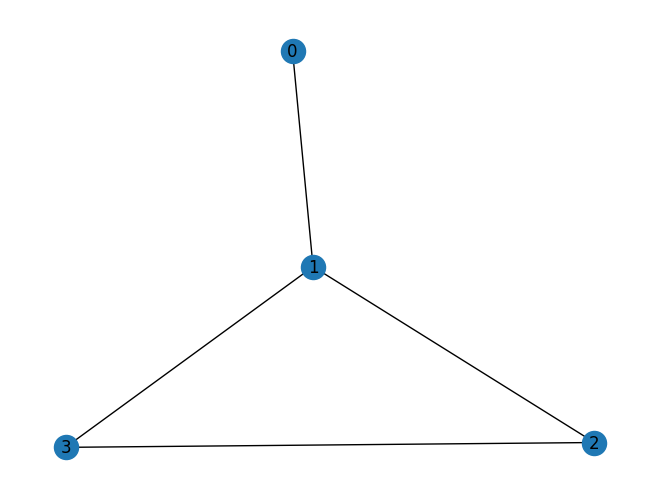

In [ ]:
edge_index = torch.tensor([[0, 1, 2, 3, 1, 2, 3, 1],
                           [1, 2, 3, 1, 0, 1, 2, 3]], dtype=torch.long).to(DEVICE)
x = torch.tensor([[-1], [0], [1], [1]], dtype=torch.float).to(DEVICE)

data = Data(x=x, edge_index=edge_index)

g = torch_geometric.utils.to_networkx(data, to_undirected=True, node_attrs=['x'])
try:
  nx.draw(g, pos=nx.spring_layout(g),  with_labels = True)
except:
  pass

In [ ]:
data = lift_nx_to_pyg(g)
data, data.x, data.edge_index

(Data(edge_index=[2, 24], x=[10, 1]),
 tensor([[0.],
         [1.],
         [0.],
         [3.],
         [0.],
         [3.],
         [0.],
         [1.],
         [1.],
         [1.]]),
 tensor([[0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7, 8, 8, 9, 9],
         [1, 3, 5, 0, 2, 1, 7, 8, 0, 4, 3, 7, 9, 0, 6, 5, 8, 9, 2, 4, 2, 6, 4, 6]]))

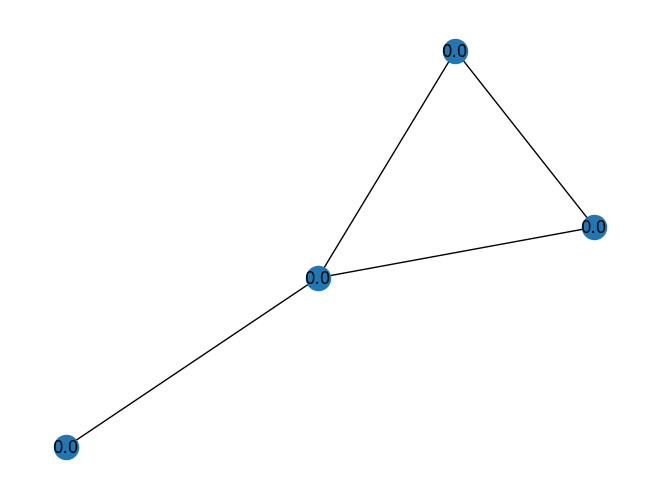

In [ ]:
draw_pyg(data, filename='examplegraph.png')
if IN_COLAB:
  plt.show()

## Dataset

In [ ]:
class ShuffleList:
    def __init__(self, data):
        self.data = data
        self.index = 0

    def __iter__(self):
        random.shuffle(self.data)
        self.index = 0
        return self

    def __next__(self):
        if self.index < len(self.data):
            value = self.data[self.index]
            self.index += 1
            return value
        else:
            raise StopIteration

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [ ]:
def build_dataset(num_nodes=NUM_NODES, num_samples=NUM_SAMPLES, degree=DEGREE):
  graph_dataset = list() 
  seed = 1234

  for _ in range(num_samples):
    while True:
      seed += 1
      graph = nx.random_regular_graph(d=degree, n=num_nodes, seed=seed)
      if nx.is_connected(graph):
        graph.x = torch.ones(num_nodes).t()
        graph_dataset.append(lift_nx_to_pyg(graph))
        break

  return ShuffleList(graph_dataset)



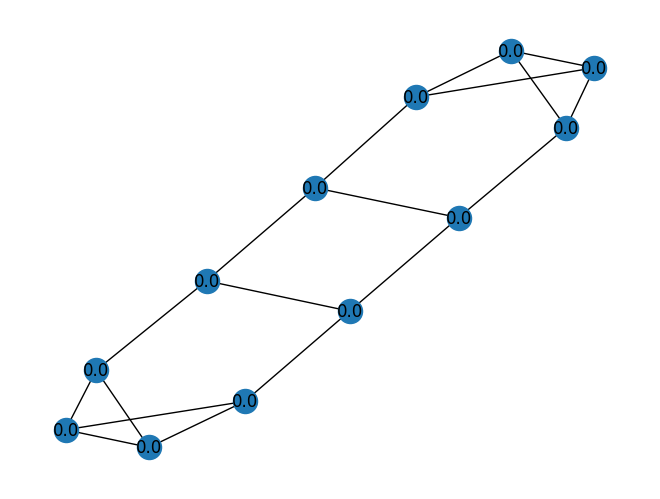

In [ ]:
dataset = build_dataset()
data = dataset[0]
draw_pyg(data)

In [ ]:
# TODO dataloader
from torch_geometric.loader import DataLoader
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE_TEST, shuffle=True)
for step, data in enumerate(train_loader):
  print(f'Step {step + 1}:')
  print('=======')
  print(f'Number of graphs in the current batch: {data.num_graphs}')
  print(data)
  print()
  print(data.x.flatten(), data.edge_index, data.batch)
  break


# for gen of training sample:
# 1) mask 0 ... (all -1) (inclusivly) 
# 2) swich exactly 1 of the unmasked

Step 1:
Number of graphs in the current batch: 10
DataBatch(edge_index=[2, 2640], x=[780, 1], batch=[780], ptr=[11])

tensor([0., 3., 0., 1., 0., 3., 0., 3., 0., 3., 0., 3., 0., 3., 0., 3., 0., 1.,
        0., 1., 0., 3., 0., 3., 3., 3., 1., 3., 3., 1., 1., 3., 3., 3., 3., 1.,
        3., 3., 3., 3., 3., 1., 1., 1., 3., 1., 3., 3., 3., 3., 3., 1., 3., 3.,
        3., 1., 3., 3., 3., 3., 3., 3., 3., 1., 3., 3., 3., 1., 1., 3., 3., 3.,
        3., 3., 1., 1., 3., 3., 0., 3., 0., 3., 0., 3., 0., 1., 0., 3., 0., 1.,
        0., 3., 0., 3., 0., 1., 0., 3., 0., 3., 0., 3., 1., 1., 1., 3., 3., 3.,
        3., 3., 3., 3., 3., 1., 3., 1., 3., 1., 3., 3., 3., 3., 3., 3., 1., 3.,
        3., 1., 3., 3., 3., 3., 1., 3., 3., 3., 3., 3., 3., 1., 3., 3., 1., 3.,
        1., 3., 1., 3., 3., 1., 3., 3., 3., 3., 3., 1., 0., 3., 0., 3., 0., 3.,
        0., 1., 0., 1., 0., 3., 0., 1., 0., 3., 0., 3., 0., 3., 0., 3., 0., 1.,
        3., 3., 3., 1., 3., 3., 1., 3., 3., 3., 3., 3., 3., 1., 3., 3., 1., 3.,
  

## Model

#### AttentionNet

In [ ]:
from torch_geometric.nn import GATv2Conv, GraphNorm, BatchNorm

class AttentionNet(torch.nn.Module):
  def __init__(self, hidden_dim=32, layer_num=6, dropout=0.1, normalization=False, single_pass_pooling=False):
    super(AttentionNet, self).__init__()

    self.mlp_list = nn.ModuleList()
    self.conv_list = nn.ModuleList()
    self.sigmoid = nn.Sigmoid()
    self.dropout = dropout
    self.graph_norms = nn.ModuleList()
    self.normalization = normalization
    self.single_pass_pooling = single_pass_pooling
    assert(hidden_dim % 2 == 0)
    input_channels = NUM_CLASSES

    for i in range(layer_num):
      in_dim = hidden_dim if i > 0 else input_channels 
      out_dim = hidden_dim if i < layer_num-1 else 1 
      self.conv_list.append(GATv2Conv(in_channels=in_dim, out_channels=hidden_dim // 2, heads=2))
      self.graph_norms.append(BatchNorm(hidden_dim))
      self.mlp_list.append(Seq(Lin(hidden_dim, hidden_dim), nn.ReLU(), Lin(hidden_dim, hidden_dim), nn.ReLU(), Lin(hidden_dim, out_dim)))

  def forward(self, x_in, edge_index, batch):
    x = note_features_to_one_hot(x_in)
    for i in range(len(self.conv_list)):
      x = self.conv_list[i](x, edge_index)
      x = F.relu(x)
      if self.normalization:
        x = self.graph_norms[i](x)
      x = self.mlp_list[i](x)
      #if i == 0:
      #  x = self.dropout(x)

    if self.single_pass_pooling:
      x = global_mask_pool(x, x_in, batch)
    else:
      x = global_mean_pool(x, batch)
    x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.sigmoid(x) + EPSILON
    return x.flatten()


In [ ]:
model = AttentionNet(single_pass_pooling=True)
model.to(DEVICE)
print(model) 
for step, data in enumerate(train_loader):
  data = data.to(DEVICE)
  print(model(data.x, data.edge_index, data.batch))
  break

AttentionNet(
  (mlp_list): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=32, bias=True)
    )
    (5): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (conv_list): ModuleList(
    (0): GATv2Conv(4, 16, heads=2)
    (1-5): 5 x GATv2Conv(32, 16, heads=2)
  )
  (sigmoid): Sigmoid()
  (graph_norms): ModuleList(
    (0-5): 6 x BatchNorm(32)
  )
)
tensor([0.8055, 0.8055, 0.8055, 0.8055, 0.8055, 0.8055, 0.8055, 0.8055, 0.8055,
        0.8055], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)


#### TransformerNet

In [ ]:
#relu = nn.Relu() ## todo: changed to relu here
from torch_geometric.nn import TransformerConv

class TransformerNet(torch.nn.Module):
  def __init__(self, hidden_dim=32, layer_num=6, dropout=0.1, normalization=False, single_pass_pooling = False):
    super(TransformerNet, self).__init__()

    self.mlp_list = nn.ModuleList()
    self.conv_list = nn.ModuleList()
    self.sigmoid = nn.Sigmoid()
    self.graph_norms = nn.ModuleList()
    self.dropout = dropout
    self.normalization = normalization
    assert(hidden_dim % 2 == 0)
    input_channels = NUM_CLASSES
    self.single_pass_pooling = single_pass_pooling


    for i in range(layer_num):
      in_dim = hidden_dim if i > 0 else input_channels 
      out_dim = hidden_dim if i < layer_num-1 else 1 
      self.conv_list.append(TransformerConv(in_channels=in_dim, out_channels=hidden_dim // 2, heads=2))
      self.graph_norms.append(BatchNorm(hidden_dim))
      self.mlp_list.append(Seq(Lin(hidden_dim, hidden_dim), nn.ReLU(), Lin(hidden_dim, hidden_dim), nn.ReLU(), Lin(hidden_dim, out_dim)))

  def forward(self, x_in, edge_index, batch):
    x = note_features_to_one_hot(x_in)
    for i in range(len(self.conv_list)):
      x = self.conv_list[i](x, edge_index)
      if self.normalization:
        x = self.graph_norms[i](x)
      x = F.dropout(x, p=self.dropout, training=self.training)
      x = self.mlp_list[i](x)
    
    if self.single_pass_pooling:
      x = global_mask_pool(x, x_in, batch)
    else:
      x = global_mean_pool(x, batch)

    x = self.sigmoid(x) + EPSILON
    return x.flatten()


In [ ]:
model = TransformerNet()
model.to(DEVICE)
print(model) 
for step, data in enumerate(train_loader):
  data = data.to(DEVICE)
  print(model(data.x, data.edge_index, data.batch))
  break

TransformerNet(
  (mlp_list): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=32, bias=True)
    )
    (5): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (conv_list): ModuleList(
    (0): TransformerConv(4, 16, heads=2)
    (1-5): 5 x TransformerConv(32, 16, heads=2)
  )
  (sigmoid): Sigmoid()
  (graph_norms): ModuleList(
    (0-5): 6 x BatchNorm(32)
  )
)
tensor([0.4738, 0.4738, 0.4739, 0.4738, 0.4739, 0.4738, 0.4738, 0.4739, 0.4739,
        0.4738], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)


#### Unet

In [ ]:
from torch_geometric.nn import GraphUNet

class Unet(torch.nn.Module):
  def __init__(self, hidden_channels=32, out_channels=1, depth=4, single_pass_pooling = False):
    super(Unet, self).__init__()
    self.sigmoid = nn.Sigmoid()
    in_channels = NUM_CLASSES
    self.single_pass_pooling = single_pass_pooling
    self.unet = GraphUNet(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, depth=depth)

  def forward(self, x_in, edge_index, batch):
    x = note_features_to_one_hot(x_in)
    x = self.unet(x, edge_index)

    if self.single_pass_pooling:
      x = global_mask_pool(x, x_in, batch)
    else:
      x = global_mean_pool(x, batch)

    x = self.sigmoid(x) + 0.0000001 # add eps to avoid div. by zero
    return x.flatten()
  

In [ ]:

model = Unet()
model.to(DEVICE)
print(model) 
for step, data in enumerate(train_loader):
  data.to(DEVICE)
  print(model(data.x, data.edge_index, data.batch))
  break

Unet(
  (sigmoid): Sigmoid()
  (unet): GraphUNet(4, 32, 1, depth=4, pool_ratios=[0.5, 0.5, 0.5, 0.5])
)
tensor([0.4809, 0.4809, 0.4809, 0.4809, 0.4810, 0.4811, 0.4811, 0.4811, 0.4811,
        0.4811], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)


#### PNA

In [ ]:
def print_inputs(*args):
    for arg in args:
        print(arg)


In [ ]:
from torch_geometric.nn import PNA
from torch_geometric.utils import degree

#train_dataset = build_dataset()

def dataset_to_degree_bin(train_dataset):
  # Compute the maximum in-degree in the training data.
  max_degree = -1
  for data in train_dataset:
      d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
      max_degree = max(max_degree, int(d.max()))

  deg = torch.zeros(max_degree + 1, dtype=torch.long)
  for data in train_dataset:
      d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
      deg += torch.bincount(d, minlength=deg.numel())
  return deg

class PNAnet(torch.nn.Module):
  def __init__(self, train_dataset_example, hidden_channels=32, depth=4, dropout=0.0, towers=2, single_pass_pooling=False, graph_transform=False, normalization=True, pre_post_layers=1):
    super(PNAnet, self).__init__()
    self.sigmoid = nn.Sigmoid()

    # Calculate x as the difference between mult_y and hidden_dim
    hidden_channels = towers * ((hidden_channels // towers) + 1)
    #out_channels = towers * ((out_channels // towers) + 1)

    in_channels = NUM_CLASSES
    if graph_transform:
      in_channels += NODE_FEATURE_EXTEND
    deg = dataset_to_degree_bin(train_dataset_example)
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    self.normalization = BatchNorm(hidden_channels) if normalization else None
    self.pnanet = PNA(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=hidden_channels, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg, dropout=dropout, towers=towers, norm=self.normalization, pre_layers=pre_post_layers, post_layers=pre_post_layers)
    self.single_pass_pooling = single_pass_pooling
    self.graph_transform = graph_transform

    self.final_mlp = Seq(Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, 1))


  def forward(self, x_in, edge_index, batch):
    x = note_features_to_one_hot(x_in)
    if self.graph_transform:
      x = extend_node_features(x, edge_index, batch)
    x = self.pnanet(x, edge_index)

    if self.single_pass_pooling:
      x = global_mask_pool(x, x_in, batch)
    else:
      x = global_mean_pool(x, batch)

    #x = x.sum(dim=1)
    x = self.final_mlp(x)
    x = self.sigmoid(x) + EPSILON # add eps to avoid div. by zero
    return x.flatten()

class PNAmulti(torch.nn.Module):
  def __init__(self, train_dataset_example, hidden_channels=32, graph_transform=False, depth=4, dropout=0.0, towers=1, model_num=5, single_pass_pooling=False, normalization=True, pre_post_layers=1):
    super(PNAmulti, self).__init__()
    self.model_num = model_num
    self.pna_list = nn.ModuleList()
    self.sigmoid = nn.Sigmoid()
    weights = torch.ones(model_num)
    self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.
    for i in range(model_num):
      # towers is i+1
      pna_model = PNAnet(train_dataset_example, hidden_channels=hidden_channels, graph_transform=graph_transform, depth=depth, dropout=dropout, towers=i+1, single_pass_pooling=single_pass_pooling, normalization=normalization, pre_post_layers=pre_post_layers)
      self.pna_list.append(pna_model)

  def get_normalized_weights(self):
    w_sigmoid = self.sigmoid(self.weights)
    w = w_sigmoid/w_sigmoid.sum()
    return w

  def forward(self, x, edge_index, batch):
    x_agg = None
    i_not = random.choice(range(len(self.pna_list))) if self.training  and len(self.pna_list) > 1 else -1 # skip 1 during training
    w = self.get_normalized_weights()
    for i, pna_model in enumerate(self.pna_list):
      if i == i_not:
        continue
      if x_agg is None:
        x_agg = pna_model(x, edge_index, batch) * w[i]
      else:
        x_agg = x_agg + pna_model( x, edge_index, batch) * w[i]
    return x_agg


In [ ]:
model = PNAmulti(build_dataset())
model.to(DEVICE)
print(model) 
for step, data in enumerate(train_loader):
  data.to(DEVICE)
  print(model(data.x, data.edge_index, data.batch))
  break

PNAmulti(
  (pna_list): ModuleList(
    (0): PNAnet(
      (sigmoid): Sigmoid()
      (normalization): BatchNorm(33)
      (pnanet): PNA(4, 33, num_layers=4)
      (final_mlp): Sequential(
        (0): Linear(in_features=33, out_features=33, bias=True)
        (1): ReLU()
        (2): Linear(in_features=33, out_features=33, bias=True)
        (3): ReLU()
        (4): Linear(in_features=33, out_features=1, bias=True)
      )
    )
    (1): PNAnet(
      (sigmoid): Sigmoid()
      (normalization): BatchNorm(34)
      (pnanet): PNA(4, 34, num_layers=4)
      (final_mlp): Sequential(
        (0): Linear(in_features=34, out_features=34, bias=True)
        (1): ReLU()
        (2): Linear(in_features=34, out_features=34, bias=True)
        (3): ReLU()
        (4): Linear(in_features=34, out_features=1, bias=True)
      )
    )
    (2): PNAnet(
      (sigmoid): Sigmoid()
      (normalization): BatchNorm(33)
      (pnanet): PNA(4, 33, num_layers=4)
      (final_mlp): Sequential(
        (0): Li

In [ ]:
model = PNAnet(build_dataset())
model.to(DEVICE)
print(model) 
for step, data in enumerate(train_loader):
  data.to(DEVICE)
  print(model(data.x, data.edge_index, data.batch))
  break

epoch: 000288  loss: -0.00010
PNAnet(
  (sigmoid): Sigmoid()
  (normalization): BatchNorm(34)
  (pnanet): PNA(4, 34, num_layers=4)
  (final_mlp): Sequential(
    (0): Linear(in_features=34, out_features=34, bias=True)
    (1): ReLU()
    (2): Linear(in_features=34, out_features=34, bias=True)
    (3): ReLU()
    (4): Linear(in_features=34, out_features=1, bias=True)
  )
)
tensor([0.4636, 0.4636, 0.4636, 0.4636, 0.4636, 0.4636, 0.4636, 0.4636, 0.4636,
        0.4636], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)


#### PNA2

In [ ]:
from torch_geometric.nn import PNAConv

class PNA2net(torch.nn.Module):
  def __init__(self, train_dataset_example, hidden_dim=32, layer_num=4, dropout=0.0, normalization=False, tower_num=5, single_pass_pooling=False):
    super().__init__()

    aggregators = ['mean', 'min', 'max', 'std', 'var', 'sum']
    scalers = ['identity', 'amplification', 'attenuation']
    deg = dataset_to_degree_bin(train_dataset_example)

    # Calculate x as the difference between mult_y and hidden_dim
    hidden_dim = tower_num * ((hidden_dim // tower_num) + 1)

    self.conv_list = nn.ModuleList()
    self.batchnorm_list = nn.ModuleList()
    self.mlp_list = nn.ModuleList()

    self.dropout = dropout
    self.normalization = normalization
    self.sigmoid = nn.Sigmoid()
    self.single_pass_pooling = single_pass_pooling

    input_channels = NUM_CLASSES
  

    for i in range(layer_num):
      in_dim = hidden_dim if i > 0 else input_channels 
      out_dim = hidden_dim if i < layer_num-1 else 1 
      self.conv_list.append(PNAConv(in_channels=in_dim, out_channels=hidden_dim, aggregators=aggregators, scalers=scalers, deg=deg, towers=tower_num, pre_layers=1, post_layers=1, divide_input=False))
      self.batchnorm_list.append(BatchNorm(hidden_dim))
      self.mlp_list.append(Seq(nn.ReLU(), Lin(hidden_dim+NUM_CLASSES+in_dim, hidden_dim+NUM_CLASSES+in_dim), nn.ReLU(), Lin(hidden_dim+NUM_CLASSES+in_dim, hidden_dim+NUM_CLASSES+in_dim), nn.ReLU(), Lin(hidden_dim+NUM_CLASSES+in_dim, out_dim)))
          
  def forward(self, x_in, edge_index, batch):
    x_onehot = note_features_to_one_hot(x_in)
    x = x_onehot.clone()
    for i in range(len(self.conv_list)):
      x_in = x.clone()
      x = self.conv_list[i](x, edge_index)
      if self.normalization:
        x = self.batchnorm_list[i](x)
      x_concat = torch.concat([x, x_onehot, x_in], dim=1)
      x = self.mlp_list[i](x_concat)
      if i < len(self.conv_list)-1:
        x = F.dropout(x, p=self.dropout, training=self.training)

    if self.single_pass_pooling:
      x = global_mask_pool(x, x_in, batch)
    else:
      x = global_mean_pool(x, batch)
      
    x = self.sigmoid(x) + EPSILON
    return x.flatten()




In [ ]:
model = PNA2net(build_dataset())
model.to(DEVICE)
print(model) 
for step, data in enumerate(train_loader):
  data.to(DEVICE)
  print(model(data.x, data.edge_index, data.batch))
  break

PNA2net(
  (conv_list): ModuleList(
    (0): PNAConv(4, 35, towers=5, edge_dim=None)
    (1-3): 3 x PNAConv(35, 35, towers=5, edge_dim=None)
  )
  (batchnorm_list): ModuleList(
    (0-3): 4 x BatchNorm(35)
  )
  (mlp_list): ModuleList(
    (0): Sequential(
      (0): ReLU()
      (1): Linear(in_features=43, out_features=43, bias=True)
      (2): ReLU()
      (3): Linear(in_features=43, out_features=43, bias=True)
      (4): ReLU()
      (5): Linear(in_features=43, out_features=35, bias=True)
    )
    (1-2): 2 x Sequential(
      (0): ReLU()
      (1): Linear(in_features=74, out_features=74, bias=True)
      (2): ReLU()
      (3): Linear(in_features=74, out_features=74, bias=True)
      (4): ReLU()
      (5): Linear(in_features=74, out_features=35, bias=True)
    )
    (3): Sequential(
      (0): ReLU()
      (1): Linear(in_features=74, out_features=74, bias=True)
      (2): ReLU()
      (3): Linear(in_features=74, out_features=74, bias=True)
      (4): ReLU()
      (5): Linear(in_feat

### Build Model

In [ ]:
def build_model(config, dataset):
  hidden_dim = config.hidden_dim
  single_pass_pooling = config.single_pass
  if config.model == "unet":
    model =  Unet(hidden_channels = hidden_dim,  out_channels = 1, depth=config.hidden_layer, single_pass_pooling=single_pass_pooling)
  elif config.model == "attention":
     model = AttentionNet(hidden_dim=hidden_dim, layer_num=config.hidden_layer, dropout=config.dropout, normalization=config.normalization, single_pass_pooling=single_pass_pooling)
  elif config.model == "transformer":
    model = TransformerNet(hidden_dim=hidden_dim, layer_num=config.hidden_layer, dropout=config.dropout, normalization=config.normalization, single_pass_pooling=single_pass_pooling)
  elif config.model == "pna":
    model = PNAnet(dataset, hidden_channels=hidden_dim, depth=config.hidden_layer, dropout=config.dropout, towers=config.towers, single_pass_pooling=single_pass_pooling, graph_transform=config.graph_transform, normalization=config.normalization, pre_post_layers=config.pre_post_layers)
  elif config.model == "pnamulti":
    model = PNAmulti(dataset, hidden_channels=hidden_dim, depth=config.hidden_layer, dropout=config.dropout, towers=config.towers, single_pass_pooling=single_pass_pooling, graph_transform=config.graph_transform, normalization=config.normalization, pre_post_layers=config.pre_post_layers)
  elif config.model == "pna2":
    model = PNA2net(dataset, hidden_dim=hidden_dim, layer_num=config.hidden_layer, dropout=config.dropout, normalization=config.normalization, single_pass_pooling=single_pass_pooling)
  else:
    ValueError("illegal net")
  return model.to(DEVICE)

## Inference

In [ ]:
def find_best_choice(model, g, test_choices, x, x_shape):
  p_0_list = list()
  p_1_list = list()
  x_noedge_list = list()
  x_edge_list = list()
  mask_indicator_list = list()

  for i, mask_indicator in enumerate(test_choices):
    x_noedge, x_edge = x.clone(), x.clone()
    x_noedge[mask_indicator] = NO_EDGE_INDICATOR
    x_edge[mask_indicator] = EDGE_INDICATOR
    batch = torch.zeros(x_shape[0], dtype=torch.long).to(DEVICE)
    p_0 = model(x_noedge.view(x_shape), g.edge_index, batch=batch).item()
    p_1 = model(x_edge.view(x_shape), g.edge_index, batch=batch).item()

    p_0_list.append(p_0/(p_0+p_1))
    p_1_list.append(p_1/(p_0+p_1))
    x_noedge_list.append(x_noedge)
    x_edge_list.append(x_edge)
    mask_indicator_list.append(mask_indicator)

  best_i = np.argmax(p_1_list)
  return p_0_list[best_i], p_1_list[best_i], x_noedge_list[best_i],  x_edge_list[best_i], mask_indicator_list[best_i]


def generate_graph_multi(model, g, choice_num=5):
  x = g.x
  x_shape = x.shape
  x = x.flatten()
  indices_of_edges = (x != DUMMY).nonzero(as_tuple=False).flatten()
  num_edges = indices_of_edges.numel()
  x[indices_of_edges] = MASK
  indices_of_edges = indices_of_edges.flatten().tolist()

  for _ in range(num_edges):
    random.shuffle(indices_of_edges)
    choice_num_i = min(choice_num, len(indices_of_edges)) 
    test_choices = indices_of_edges[0:choice_num_i]
    p_0, p_1, x_noedge, x_edge, mask_indicator = find_best_choice(model, g, test_choices, x, x_shape)
    random_selection_index = int(np.random.choice([0, 1], size=1, p=[p_0, p_1]))
    x = (x_noedge, x_edge)[random_selection_index]
    indices_of_edges.remove(mask_indicator)

  g.x = x.reshape(x_shape)
  return g

In [ ]:
def generate_graph_singlepass(model, g):
  # does not have multi
  model.eval()
  x = g.x
  x_shape = x.shape
  x = x.flatten()
  indices_of_edges = (x != DUMMY).nonzero(as_tuple=False).flatten()
  num_edges = indices_of_edges.numel()
  x[indices_of_edges] = MASK
  indices_of_edges = indices_of_edges.flatten().tolist()
  random.shuffle(indices_of_edges)
  batch = torch.zeros(x_shape[0], dtype=torch.long).to(DEVICE)

  for edge_index in indices_of_edges:
    x[edge_index] = -1.0
    edge_prob = model(x.view(x_shape), g.edge_index, batch=batch).item()
    assert(edge_prob > 0.0 and edge_prob < 1.0)
    if random.random() < edge_prob:
      x[edge_index] = EDGE_INDICATOR
    else:
      x[edge_index] = NO_EDGE_INDICATOR

  g.x = x.reshape(x_shape)
  return g


In [ ]:
@torch.inference_mode()
def generate_graphs(num, epoch_i, model, g_like, config):
  mean_degree_list = list()
  var_degree_list = list()
  for j in range(num):
    if config.single_pass:
      g = generate_graph_singlepass(model, g_like)
    else:
      g = generate_graph_multi(model, g_like, choice_num = config.candidate_selection_radius)
    nx_orig_graph = draw_pyg(g, filename=f"generated_graph_epoch{str(epoch_i).zfill(5)}_sample{str(j).zfill(5)}.jpg")
    degree_list = [nx_orig_graph.degree(i) for i in nx_orig_graph.nodes()]
    mean_degree_list.append(np.mean(degree_list))
    var_degree_list.append(np.var(degree_list))
  return np.mean(mean_degree_list), np.mean(var_degree_list)

## Generat Samples for Training

In [ ]:
def gen_random_training_sample_unused(x):
  x_masked = x.clone().reshape(-1)
  indices_of_edges = (x_masked != DUMMY).nonzero(as_tuple=False).flatten()
  num_edges = indices_of_edges.numel()
  num_masked = torch.randint(1, num_edges+1, size=(1,), device=DEVICE)
  #num_masked = sample_num_masked_geometric(1, num_edges+1)

  shuffled_indices_of_edges = indices_of_edges[torch.randperm(indices_of_edges.numel())]
  indices_of_edges_to_mask = shuffled_indices_of_edges[:num_masked]
  
  gt_value = x_masked[indices_of_edges_to_mask[0]].item() # we will change the first value back
  x_masked[indices_of_edges_to_mask] = MASK


  x_masked_0 = x_masked.clone()
  x_masked_0[indices_of_edges_to_mask[0]] = NO_EDGE_INDICATOR
  x_masked_0 = x_masked_0.reshape(x.shape)

  x_masked_1 = x_masked.clone()
  x_masked_1[indices_of_edges_to_mask[0]] = EDGE_INDICATOR
  x_masked_1 = x_masked_1.reshape(x.shape)

  if gt_value == NO_EDGE_INDICATOR:
    return x_masked_0, x_masked_1
  elif gt_value == EDGE_INDICATOR:
    return x_masked_1, x_masked_0 
  assert(False)

  return None

In [ ]:
def sample_mask_and_flip(batch, x):
  num_graphs = batch.view(-1)[-1]
  x_id_mask = list()
  x_id_flip = list()

  for graph_id in range(num_graphs+1):
    #num_nodes = (batch == graph_id).sum()
    #indices_of_edges = (x != DUMMY and batch == graph_id).nonzero(as_tuple=False)
    edge_indicator = x.view(-1) != DUMMY
    batch_indicator = batch.view(-1) == graph_id 
    indices_of_edges = torch.nonzero(batch_indicator & edge_indicator)
    indices_of_edges = indices_of_edges.flatten().tolist()
    random.shuffle(indices_of_edges)
    x_id_flip.append(indices_of_edges[-1])
    num_masked = random.choice(range(len(indices_of_edges)))
    x_id_mask = x_id_mask + indices_of_edges[:num_masked]

  mask_and_flip_indicator = torch.zeros(batch.numel(), dtype=torch.long).to(DEVICE)
  mask_and_flip_indicator[x_id_mask] = 1
  mask_and_flip_indicator[x_id_flip] = 2

  return mask_and_flip_indicator

def mask_x_based_on_indicator(x, mask_and_flip_indicator):
  x_new = x.clone()
  to_mask = mask_and_flip_indicator == 1
  x_new.view(-1)[to_mask] = MASK
  return x_new


# this is done inplace!
def flip_x_based_on_indicator(x, mask_and_flip_indicator):
  to_flip = (mask_and_flip_indicator == 2)#.to(DEVICE)
  x = x.clone()  #sadly in-place operation not allowed here

  #x[to_flip] = -x[to_flip]

  x[to_flip] = torch.where(x[to_flip] == EDGE_INDICATOR, torch.tensor(NO_EDGE_INDICATOR).to(DEVICE), torch.tensor(EDGE_INDICATOR).to(DEVICE))

  return x

In [ ]:
for step, data in enumerate(train_loader):
  data.to(DEVICE)
  mask_and_flip_indicator = sample_mask_and_flip(data.batch, data.x)
  break


x = (mask_x_based_on_indicator(data.x, mask_and_flip_indicator))
xz = x.clone()
xx = (flip_x_based_on_indicator(x, mask_and_flip_indicator))

(xz == xx).flatten()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True, 

## Compute Loss

In [ ]:
bce_loss = nn.BCELoss()
def reduce_loss(loss_for_graph, config):
  # loss_for_graph should be > 0
  if config.loss == "l1":
    return loss_for_graph.sum() 
  elif config.loss == "l2":
    return F.mse_loss(loss_for_graph, torch.zeros_like(loss_for_graph))
  elif config.loss == "bce":
    return bce_loss(loss_for_graph, torch.zeros_like(loss_for_graph))
  else:
    raise ValueError("Illegal loss value")


## Training Loop

In [ ]:
def prepare_x_for_single_pass(mask_and_flip_indicator, x):
  x_new = x.clone()
  to_mask = mask_and_flip_indicator == 1
  x_new.view(-1)[to_mask] = MASK
  choice_indicator = mask_and_flip_indicator == 2
  x_new.view(-1)[choice_indicator] = -1 # this will be set to zero in the one hot encoding step
  gt = x.clone().flatten()[choice_indicator]
  gt = torch.where(gt == EDGE_INDICATOR, torch.tensor(1.0, device = DEVICE), torch.zeros_like(gt))
  return x_new, gt

In [ ]:
def single_pass_prediction(data, model, config):
  mask_and_flip_indicator = sample_mask_and_flip(data.batch, data.x)
  x_in, out_gt = prepare_x_for_single_pass(mask_and_flip_indicator, data.x)

  if model.training: x_in = flip_edges_randomly(x_in, config.noise_probability)

  out_prediction = model(x_in, data.edge_index, data.batch) # between 0 ,1 

  #print("out gt: ", out_gt.flatten(), "   out pred:   ", out_prediction.flatten())

  loss_for_graph =  torch.abs(out_prediction.flatten() - out_gt.flatten()) # between 0 and 1
  return loss_for_graph 

In [ ]:
def multi_pass_prediction(data, model, config):
  mask_and_flip_indicator = sample_mask_and_flip(data.batch, data.x) # this then should also return gt 
  x = mask_x_based_on_indicator(data.x, mask_and_flip_indicator)

  if model.training: x = flip_edges_randomly(x, config.noise_probability)

  out_correct = model(x, data.edge_index, data.batch)  # is supposed to be 1 everywhere
  x = flip_x_based_on_indicator(x, mask_and_flip_indicator)  # important to use x here and not data.x
  out_incorrect = model(x, data.edge_index, data.batch) # is supposed to be 0 everywhere
  loss_for_graph =  out_incorrect - out_correct # between -1 and 1
  loss_for_graph = (loss_for_graph + 1.0) / 2.0   # between 0 and 1,
  return loss_for_graph 

In [ ]:
def feed_data_to_model(data, model, config):
  if config.single_pass == True:
    return single_pass_prediction(data, model, config)
  return multi_pass_prediction(data, model, config)

### Start Agent

In [ ]:
def start_agent(config):
  graph_dataset = build_dataset()
  model = build_model(config, graph_dataset)
  wandb.log({"num_parameters": sum(p.numel() for p in model.parameters())})

  optimizer = Adam(model.parameters(), lr = config.learning_rate) 
  train_loader = DataLoader(graph_dataset, batch_size=config.batch_size, shuffle=True)

  for epoch_i in range(NUM_EPOCHS):
    loss_list = list()
    for step, data in enumerate(train_loader):
      data.to(DEVICE)
      model.train()
      model.zero_grad()

      loss_for_graph = feed_data_to_model(data, model, config) # between 0 and 1, probabilty of the incorrect choice
      loss = reduce_loss(loss_for_graph, config)
      loss.backward()
      optimizer.step()

      loss =  ((loss_for_graph.mean()).item()  -0.5 ) * 2.0 # between - 0.5 and 0.5 -> between - 1 and 1
      loss_list.append(loss)
      #wandb.log({"epoch": epoch_i+1, "loss": np.mean(loss_list)})

    print('epoch: {:06}  loss: {:.5f}'.format(epoch_i+1 ,np.mean(loss_list)))
    # early stopping
    if np.mean(loss_list) > -0.000001 and (epoch_i > 199 and epoch_i % 100 == 0):
      return

    if epoch_i % 20 == 0 or epoch_i == NUM_EPOCHS-1:
      dummy_graph = graph_dataset[0].clone().to(DEVICE)
      num = NUM_GRAPHS_GENERATE if epoch_i != NUM_EPOCHS-1 else NUM_GRAPHS_GENERATE*5
      deg_mean, deg_var = generate_graphs(NUM_GRAPHS_GENERATE, epoch_i, model, dummy_graph, config)
      generator_loss = (DEGREE-deg_mean)**2 + deg_var
      wandb.log({"graph-unmasking/gen-loss": generator_loss, "mean degree": deg_mean, "mean degree var":deg_var, "graph-unmasking/loss": np.mean(loss_list)})
      print(deg_mean, deg_var)

  torch.save(model.state_dict(), "model.weights")
  wandb.log_artifact("model.weights", name=f'nn_weights_{SWEEP_ID}', type='weights') 



    

In [ ]:
def start_agent_envelope():
  try:
    with wandb.init():
      config = wandb.config
      set_seeds(SWEEP_ID)
      print(SWEEP_ID, config)
      if not IN_COLAB:
        for python_file in sorted(glob.glob('*.ipynb')):
          wandb.log_artifact(python_file, name=f"src_ipynb_{SWEEP_ID}", type="my_dataset")
        for python_file in sorted(glob.glob('*.py')):
          wandb.log_artifact(python_file, name=f"src_py_{SWEEP_ID}", type="my_dataset")
      return start_agent(config)
  except Exception:
    print(traceback.format_exc())
    wandb.log({"graph-unmasking/gen-loss": -1,  "epoch": -1, "graph-unmasking/loss": -1})

Create sweep with ID: 04w4qh3j
Sweep URL: https://wandb.ai/nextaid/toad_prepost/sweeps/04w4qh3j


wandb: Agent Starting Run: 00mvlb25 with config:
wandb: 	batch_size: 100
wandb: 	candidate_selection_radius: 1
wandb: 	dropout: 0
wandb: 	graph_transform: True
wandb: 	hidden_dim: 32
wandb: 	hidden_layer: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: l2
wandb: 	model: pna
wandb: 	noise_probability: 0.05
wandb: 	normalization: True
wandb: 	pre_post_layers: 3
wandb: 	single_pass: False
wandb: 	towers: 1


04w4qh3j {'batch_size': 100, 'candidate_selection_radius': 1, 'dropout': 0, 'graph_transform': True, 'hidden_dim': 32, 'hidden_layer': 4, 'learning_rate': 0.0001, 'loss': 'l2', 'model': 'pna', 'noise_probability': 0.05, 'normalization': True, 'pre_post_layers': 3, 'single_pass': False, 'towers': 1}
epoch: 000001  loss: -0.00000
5.35 2.2194444444444446
epoch: 000002  loss: -0.00000
epoch: 000003  loss: -0.00001
epoch: 000004  loss: -0.00002
epoch: 000005  loss: -0.00005
epoch: 000006  loss: -0.00014
epoch: 000007  loss: -0.00034
epoch: 000008  loss: -0.00087
epoch: 000009  loss: -0.00177
epoch: 000010  loss: -0.00339
epoch: 000011  loss: -0.00520
epoch: 000012  loss: -0.00638
epoch: 000013  loss: -0.00764
epoch: 000014  loss: -0.01383
epoch: 000015  loss: -0.01643
epoch: 000016  loss: -0.02406
epoch: 000017  loss: -0.02572
epoch: 000018  loss: -0.04367
epoch: 000019  loss: -0.03941
epoch: 000020  loss: -0.06975
epoch: 000021  loss: -0.08582
5.416666666666666 2.558333333333333
epoch: 000

graph-unmasking/gen-loss,▇█▆▆▆▄▃▇▆▃▄▅▄▄▄▄▄▁▄▆▆▅▅▄▅▆▄▇▅▆▅▅▇▅▅▂▃▃▃▄
graph-unmasking/loss,█▄▆██████▁███████▆██████████████████████
mean degree,██▇▇█▇▆█▇▅▇▇▆▆▆▇▇▄▆▇▇▇▇▆▇▇▇█▇▇▇▇▇▇▇▁▅▅▆▆
mean degree var,▇█▅█▆▄▅▇▇▆▄▆▄▄▅▃▃▂▅▆▅▆▆▄▆▆▅▅▄▆▆▆█▅▄▁█▇█▇
num_parameters,▁
graph-unmasking/gen-loss,4.3275
graph-unmasking/loss,-0.0
mean degree,4.38333
mean degree var,2.41389
num_parameters,75194


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7iq763wk with config:
wandb: 	batch_size: 50
wandb: 	candidate_selection_radius: 1
wandb: 	dropout: 0
wandb: 	graph_transform: True
wandb: 	hidden_dim: 32
wandb: 	hidden_layer: 5
wandb: 	learning_rate: 5e-05
wandb: 	loss: l2
wandb: 	model: pna
wandb: 	noise_probability: 0.05
wandb: 	normalization: True
wandb: 	pre_post_layers: 1
wandb: 	single_pass: False
wandb: 	towers: 1


04w4qh3j {'batch_size': 50, 'candidate_selection_radius': 1, 'dropout': 0, 'graph_transform': True, 'hidden_dim': 32, 'hidden_layer': 5, 'learning_rate': 5e-05, 'loss': 'l2', 'model': 'pna', 'noise_probability': 0.05, 'normalization': True, 'pre_post_layers': 1, 'single_pass': False, 'towers': 1}
epoch: 000001  loss: -0.00001
5.35 2.2194444444444446
epoch: 000002  loss: -0.00005
epoch: 000003  loss: -0.00012
epoch: 000004  loss: -0.00046
epoch: 000005  loss: -0.00135
epoch: 000006  loss: -0.00297
epoch: 000007  loss: -0.00566
epoch: 000008  loss: -0.01399
epoch: 000009  loss: -0.02557
epoch: 000010  loss: -0.01830
epoch: 000011  loss: -0.03209
epoch: 000012  loss: -0.04341
epoch: 000013  loss: -0.03273
epoch: 000014  loss: -0.04840
epoch: 000015  loss: -0.05595
epoch: 000016  loss: -0.06375
epoch: 000017  loss: -0.07935
epoch: 000018  loss: -0.10891
epoch: 000019  loss: -0.09688
epoch: 000020  loss: -0.14499
epoch: 000021  loss: -0.04393
5.116666666666666 2.0972222222222223
epoch: 0000

wandb: Ctrl + C detected. Stopping sweep.


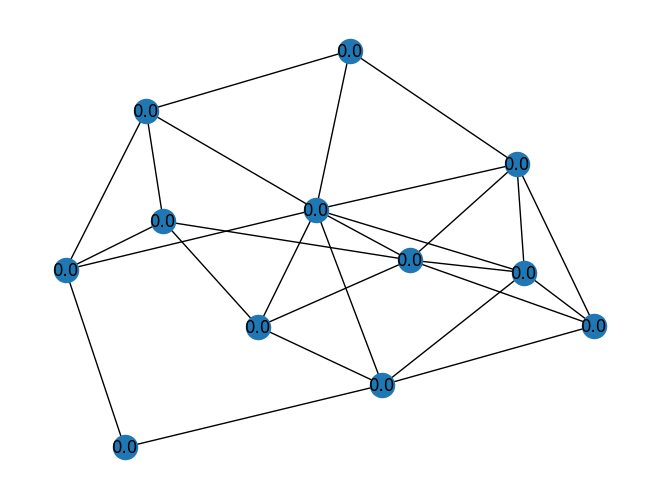

In [ ]:
os.environ["WANDB_MODE"] = "online" #"dryrun"

SWEEP_ID = wandb.sweep(sweep_config, project=PROJECT_NAME)
wandb.agent(SWEEP_ID, project=PROJECT_NAME, function=start_agent_envelope, count=500)